# Comparing Different Model Architectures

This notebook compares different model architectures for the pet classification task. Run this notebook with a fresh kernel to avoid GPU memory issues.

In [1]:
# Import the necessary libraries
from fastai.vision.all import *
import gc  # Add garbage collector module for memory management

## Data Preparation

We'll use the same pet dataset and DataBlock as before.

In [2]:
# Set the path to the local data directory
path = Path('/home/satishthakur/.fastai/data/oxford-iiit-pet')
path.exists()

True

In [3]:
# Function to get the label from the filename
def is_cat(fname):
    # Extract just the file name from the path
    name = str(fname.name)
    # In this dataset, filenames that start with uppercase are cats
    return name[0].isupper()

In [4]:
# Create a DataBlock with data augmentation
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=is_cat,
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms())

In [5]:
# Create the DataLoaders
dls = pets.dataloaders(path/"images", bs=16)  # Using a smaller batch size to reduce memory usage

## Memory Management Techniques

When working with larger models, it's helpful to manage GPU memory carefully:

In [6]:
# Check available GPU memory before training
import torch
if torch.cuda.is_available():
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Total GPU memory: 8.24 GB
Allocated GPU memory: 0.01 GB
Reserved GPU memory: 0.03 GB


In [7]:
# Function to clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        print(f"GPU memory after clearing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

## Training with ResNet34

Let's establish a baseline with ResNet34.

In [8]:
# Create and train the ResNet34 model
learn_resnet34 = vision_learner(dls, resnet34, metrics=error_rate)
learn_resnet34.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.256905,0.052109,0.018945,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.090955,0.017220,0.004060,00:25


In [9]:
# Evaluate the ResNet34 model
resnet34_error = learn_resnet34.validate()[1]
print(f"ResNet34 error rate: {resnet34_error:.4f}")

# Save results for comparison
results = {'resnet34': resnet34_error}

ResNet34 error rate: 0.0041


In [10]:
# Clear memory before trying a new model
learn_resnet34 = None  # Remove reference to the model
clear_gpu_memory()

GPU memory after clearing: 0.02 GB


## Training with ResNet50

Now let's try ResNet50, which is deeper and potentially more powerful.

In [11]:
# Create and train the ResNet50 model with a smaller batch size
learn_resnet50 = vision_learner(dls, resnet50, metrics=error_rate)
learn_resnet50.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.166778,0.030210,0.011502,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.067656,0.016948,0.004736,00:46


In [12]:
# Evaluate the ResNet50 model
resnet50_error = learn_resnet50.validate()[1]
print(f"ResNet50 error rate: {resnet50_error:.4f}")

# Update results
results['resnet50'] = resnet50_error

ResNet50 error rate: 0.0047


In [13]:
# Clear memory again
learn_resnet50 = None
clear_gpu_memory()

GPU memory after clearing: 0.02 GB


## Training with DenseNet121

DenseNet is another architecture known for its dense connections between layers.

In [14]:
# Create and train a DenseNet121 model
learn_densenet = vision_learner(dls, densenet121, metrics=error_rate)
learn_densenet.fine_tune(1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/satishthakur/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:00<00:00, 64.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.144744,0.021461,0.009472,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.046794,0.009949,0.003383,00:59


In [15]:
# Evaluate the DenseNet model
densenet_error = learn_densenet.validate()[1]
print(f"DenseNet121 error rate: {densenet_error:.4f}")

# Update results
results['densenet121'] = densenet_error

DenseNet121 error rate: 0.0034


In [16]:
# Clear memory again
learn_densenet = None
clear_gpu_memory()

GPU memory after clearing: 0.02 GB


## If GPU Memory Allows: Training with EfficientNet

If you have enough GPU memory, you can try EfficientNet, which is optimized for accuracy and efficiency.

In [17]:
# Try/except block in case the model is too large for GPU memory
try:
    # Create and train an EfficientNet model
    learn_efficient = vision_learner(dls, efficientnet_b0, metrics=error_rate)
    learn_efficient.fine_tune(1)
    
    # Evaluate the EfficientNet model
    efficient_error = learn_efficient.validate()[1]
    print(f"EfficientNet-B0 error rate: {efficient_error:.4f}")
    
    # Update results
    results['efficientnet_b0'] = efficient_error
    
    # Clear memory
    learn_efficient = None
    clear_gpu_memory()
    
except Exception as e:
    print(f"Error training EfficientNet: {e}")
    print("Consider reducing batch size or trying a smaller model")

/home/satishthakur/codebase/data-science/machine-learning/fast-ai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/satishthakur/codebase/data-science/machine-learning/fast-ai/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/satishthakur/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|████████████████████████████████████████████████████████

epoch,train_loss,valid_loss,error_rate,time
0,0.266637,0.092699,0.040595,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.146180,0.038133,0.015562,00:29


EfficientNet-B0 error rate: 0.0156
GPU memory after clearing: 0.02 GB


## Memory-Efficient Approaches

For very limited GPU memory situations, you can use these techniques:

In [18]:
# 1. Even smaller batch size
dls_small = pets.dataloaders(path/"images", bs=8)

# 2. Use mixed precision training
from fastai.callback.fp16 import *

try:
    learn_mixed = vision_learner(dls_small, resnet50, metrics=error_rate).to_fp16()
    learn_mixed.fine_tune(1)
    
    mixed_error = learn_mixed.validate()[1]
    print(f"ResNet50 (FP16) error rate: {mixed_error:.4f}")
    
    results['resnet50_fp16'] = mixed_error
    
    learn_mixed = None
    clear_gpu_memory()
except Exception as e:
    print(f"Error with mixed precision: {e}")

/home/satishthakur/codebase/data-science/machine-learning/fast-ai/.venv/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/satishthakur/codebase/data-science/machine-learning/fast-ai/.venv/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,0.279563,0.054009,0.017591,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.112415,0.021945,0.006089,00:43


ResNet50 (FP16) error rate: 0.0061
GPU memory after clearing: 0.02 GB


## Compare All Results

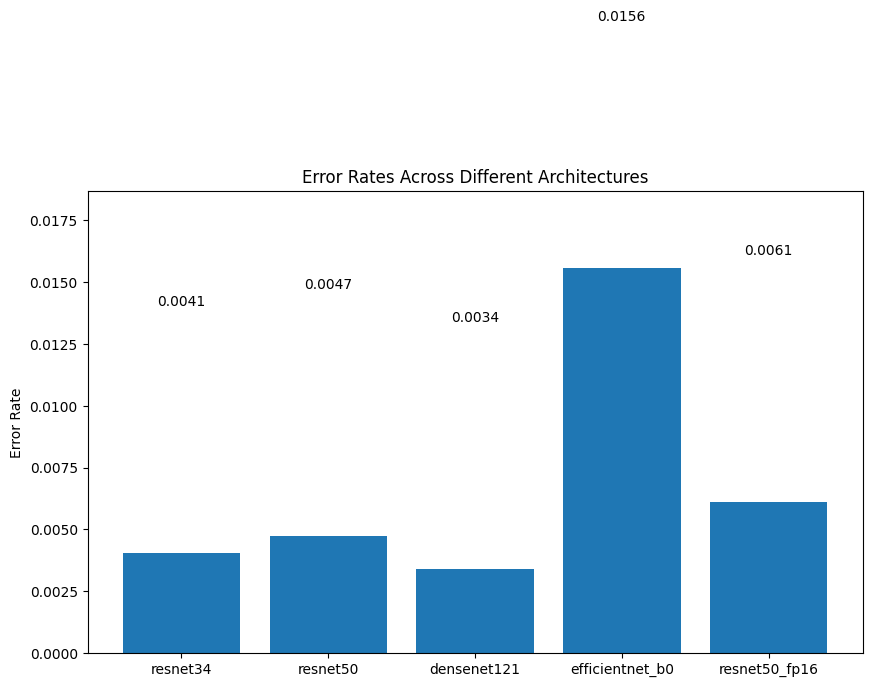

The best performing model is densenet121 with an error rate of 0.0034


In [19]:
# Compare all model results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Error Rates Across Different Architectures')
plt.ylabel('Error Rate')
plt.ylim(0, max(results.values()) * 1.2)
for i, (key, value) in enumerate(results.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center')
plt.show()

# Print the best model
best_model = min(results.items(), key=lambda x: x[1])
print(f"The best performing model is {best_model[0]} with an error rate of {best_model[1]:.4f}")

## Tips for Working with Limited GPU Memory

1. **Reduce batch size**: Smaller batches require less memory
2. **Use mixed precision training**: FP16 uses half the memory of FP32
3. **Reduce image size**: 224x224 is standard, but you can try 192x192 or smaller
4. **Use a gradient accumulation callback**: Train on micro-batches and update weights less frequently
5. **Choose smaller architectures**: ResNet18 uses less memory than ResNet50
6. **Clean up memory between model training**: Delete model variables and use `torch.cuda.empty_cache()`
7. **Restart the kernel**: Sometimes the simplest solution is to restart the notebook

Remember that there's always a trade-off between model size, training time, and accuracy.